# **Stage 3 - Using StableBaselines3 for DRL Implementation - part 1** 

## Scope - *implementing the current successful DRL models using StableBaselines3 library to apply hyperparameter optimization using Optuna*
References:- 
1. Reinforcement Learning Tips and Tricks - https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html 
2. DDPG - https://stable-baselines3.readthedocs.io/en/master/modules/ddpg.html 

### RL Tips and Tricks (from reference 1)

#### Current Limitations of Reinforcement Learning 

- Model-free RL algorithms (i.e. all the algorithms implemented in SB) are usually sample inefficient. They require a lot of samples (sometimes millions of interactions) to learn something useful. That’s why most of the successes in RL were achieved on games or in simulation only. For instance, in this work by ETH Zurich, the ANYmal robot was trained in simulation only, and then tested in the real world. 

- One last limitation of RL is the instability of training. That is to say, you can observe during training a huge drop in performance. This behavior is particularly present in DDPG, that’s why its extension TD3 tries to tackle that issue. Other method, like TRPO or PPO make use of a trust region to minimize that problem by avoiding too large updates.

In [1]:
import os, sys, json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import lfilter, iirdesign, zpk2tf, freqz

import gymnasium as gym 
from gymnasium import spaces

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.env_checker import check_env

sys.path.append('../')
from stage1_helper import create_target_and_jammed_signals, Spectrum, SNR, power
from stage2_helper import polar2cmplx

2024-01-01 14:14:13.220792: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-01 14:14:14.124803: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 14:14:14.124851: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 14:14:14.129128: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 14:14:14.501720: I tensorflow/core/platform/cpu_feature_g

In [2]:
# define constants
S = 100 
SAMPLING_FREQ = 44_100 # Hz 
CUT_OFF_FREQ = 5_000 # Hz 
INTERFERENCE_CENTER_FREQ = 15_000 # Hz 

### **Define the Environment** 

- Here, let's use the current IIR filtering environment. 
- Normalize the state (audio sample sequence) returned from `reset` and `step` methods. 
- Other changes: Disabled the `options` argument of the `reset` function of the environment because of the incompatibility with the SB3 `DummyVecEnv`.

In [3]:
def NormalizeState(state):
    """
    Normalizes a given state (equivalent to performing layer normalization)
    :param state: the state (observation) (1-D) vector to normalize
    """

    return (state - np.mean(state)) / np.std(state)

In [6]:
# receiver environment with IIR filtering
class ReceiverEnvWithSecondOrderIIR_1(gym.Env):
    """
    A custom environment developed in the accordance with gym environment API that immitates a receiver of jammed audio with IIR filtering. 
    :param S: signal partition size which represents a state 
    :param cut_off_freq: the frequency to truncate the audio spectrum to generate the target signal; equivalent to the ideal cut-off frequency of the learned filter
    :param interference_center_freq: the frequency to shift the target spectrum to generate the non-overlapping interference
    :param audio_json: path of a json file containing the names of the audio wav files the environment can access\
        put the audio file names without the .wav extension in a json array inside the file
    """

    # define constants 
    MIN_BUFFER_SIZE = 10 # RAISE THIS LATER!!!
    EPISODE_LENGTH  = np.inf # np.inf
    MAX_TOTAL_NUM_OF_STEPS = np.inf
    # OBSERVATION_SPACE_BOUND = 5

    def __init__(self, S:int, cut_off_freq:int, interference_center_freq:int, audio_json:str = '../stage_1/audio_files/audio_files.json'):

        super(ReceiverEnvWithSecondOrderIIR_1, self).__init__()

        # ----- verifying input arguments and setting them as class atributes ----
        # signal partition size
        if S < self.MIN_BUFFER_SIZE:
            raise Exception(f"the buffer size 'S' must be larger than MIN_BUFFER_SIZE, {self.MIN_BUFFER_SIZE}: given {S}")
        self.S = S

        # other parameters
        self.cut_off_freq = cut_off_freq
        self.interference_center_freq = interference_center_freq
        self.audio_json = audio_json

        # ----------------------------- Action Space -----------------------------
        # action - choosing fixed gain k, zeros, and poles of an N-th order IIR filter
        # note that the action is NOT TUNING/,ADJUSTING, or CHANGING the coefficeints of an existing filter. 
        action_shape = (5, )
        self.action_space = spaces.Box(low=0, high=1, shape=action_shape, dtype=np.float32) # float16 -> float32, lower limit must be 0. 

        # ----------------------------- State Space ------------------------------
        state_shape = (self.S, )
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=state_shape, dtype=np.float64)

        # ------------------------- other class attributes ------------------------
        self.global_counter = 0  # a counter to keep track of the number of elapsed time steps of the environment
        self.counter = 0         # a counter to keep track of the number of elapsed time steps in the current episode
        self.episode_counter = 0 # a counter to keep track of the number of total episodes

    def reset(self, seed=None, options=None):

        super().reset(seed=seed, options=None) # options must be forced to None

        # set show_effect option
        self.show_effect = True
        if isinstance(options, dict) and 'show_effect' in options:
            self.show_effect = options['show_effect']
        
        # reset the counters
        if isinstance(options, dict) and 'reset_all' in options and options['reset_all'] == True:
            self.global_counter  = 0
            self.episode_counter = 0
        self.counter = 0
        self.episode_counter += 1

        print('\n' + "-" * 50 + f"episode no: {self.episode_counter}" + "-" * 50)

        # for each episode, choose the audio signal specified by `audio_num` in the options
        with open(self.audio_json) as audio_json_file:
            train_audio_names = json.load(audio_json_file)["train"]
        audio_num = 1 # default audio track - 'arms_around_you-MONO.wav'
        if isinstance(options, dict) and 'audio_num' in options:
            audio_num = options['audio_num']
        
        # i = np.random.randint(low=1, high=self.audio_num) # len(train_audio_names)
        # create the target and jammed signals
        target_signal, jammed_signal = create_target_and_jammed_signals(train_audio_names[audio_num], self.cut_off_freq, self.interference_center_freq, self.S)
        self.target_signal = target_signal
        self.jammed_signal = jammed_signal
        print()

        # create another internal state
        self.internal_state = jammed_signal[:self.S]

        # return the initial state 
        self.state = NormalizeState(self.internal_state)

        # declare the initial conditions in the start of the audio
        self.initial_conds = np.zeros(2)

        info = {}

        # return the initial state and info
        return self.state, info

    def step(self, action):

        # increment the counters
        self.global_counter += 1
        self.counter += 1

        # ----- create the filter -----
        # extract the zero, pole, and gain, and find the transfer function of the filter
        z = polar2cmplx(action[0], np.pi * action[1])
        p = polar2cmplx(action[2], np.pi * action[3])
        k = action[4]

        zs = (z, np.conjugate(z)) # array of zeros of TF
        ps = (p, np.conjugate(p)) # array of poles of TF

        b, a = zpk2tf(zs, ps, k)

        # get signal partition from the buffer (internal state)
        partition = self.internal_state

        # generating the next state
        terminated = False
        if self.S * (self.counter + 1) >= len(self.jammed_signal):
            terminated = True
        else:
            self.internal_state = self.jammed_signal[self.S * self.counter : self.S * (self.counter + 1)]
            self.state = NormalizeState(self.internal_state)
        
        # apply the IIR filter to the current state and set the initial conditions for the next state
        filtered, self.initial_conds = lfilter(b, a, partition, zi=self.initial_conds)
        target = self.target_signal[self.S * (self.counter - 1) : self.S * self.counter]

        # calculate the reward (SNR)
        reward = SNR(target, filtered)
        if np.isnan(reward):
            print(f"reward value is not a number... \nfilter: {filter}; assigning -20dB as the reward...")
            reward = -20 # assign a very large negative reward
            # raise Exception(f"reward value is not a number...\ntarget: {target}\nfiltered: {filtered}\nfilter: {filter}")
        
        # if self.counter % 50 == 1:
        if self.show_effect: print(f"step: {self.counter}, SNR: {reward}, filter: {b}, {a}")
        
        # truncating the episode
        truncated = False
        if self.episode_counter == self.EPISODE_LENGTH or self.global_counter == self.MAX_TOTAL_NUM_OF_STEPS:
            truncated = True
        
        info = {} 

        return self.state, reward, terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass

- Now, check whether the environment satisfies the Gym interface. 

In [ ]:
# create an envirnoment instance
env_for_check = ReceiverEnvWithSecondOrderIIR_1(
    S = S,
    cut_off_freq = CUT_OFF_FREQ, 
    interference_center_freq = INTERFERENCE_CENTER_FREQ
)

# check the environment interface 
check_env(env_for_check)

- The environment satisfies the Gym interface requirements; so, it is SB3 compatible. 

### **Verify the New Environment with the Current Working Custom DDPG Model**

- Define the custom DDPG class again...

In [28]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.losses import MSE

In [29]:
# =============================== REPLAY BUFFER ===============================
class ReplayBuffer:
    def __init__(self, max_size, state_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0

        self.state_memory     = np.zeros((self.mem_size, *state_shape))
        self.action_memory    = np.zeros((self.mem_size, n_actions))
        self.reward_memory    = np.zeros(self.mem_size)
        self.new_state_memory = np.zeros((self.mem_size, *state_shape))
        self.terminal_memory  = np.zeros(self.mem_size, dtype=np.bool_) # using np.bool is really useful when pytorch is used.

    def store_transition(self, state, action, reward, new_state, done):
        index = self.mem_cntr % self.mem_size # implement a queue

        self.state_memory[index]     = state
        self.action_memory[index]    = action
        self.reward_memory[index]    = reward
        self.new_state_memory[index] = new_state
        self.terminal_memory[index]  = done # problematic !!!

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size, replace=False) # replace = False -> in a single batch, no element gets sampled more than once. 

        states     = self.state_memory[batch]
        actions    = self.action_memory[batch]
        rewards    = self.reward_memory[batch]
        new_states = self.new_state_memory[batch]
        dones      = self.terminal_memory[batch]

        return states, actions, rewards, new_states, dones



# =============================== CRITIC NETWORK ===============================
class CriticNetwork(keras.Model):
    def __init__(
            self,
            name, # model name (required by tf.keras.Model)
            fc1_dims,
            fc2_dims,
            chkpt_dir='tmp/ddpg/'
    ):
        super(CriticNetwork, self).__init__()

        self.model_name = name # do not use 'self.model'; it is a reserved variable name in tf
        self.checkpoint_dir  = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, self.model_name+'_ddpg.h5') 
        # extensions for saving keras models: legacy '.h5' -> TF 1.X, '.tf' -> TF 2.X

        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        # # define network layers 
        # self.fc1 = Dense(self.fc1_dims, activation='relu')
        # self.fc2 = Dense(self.fc2_dims, activation='relu')
        # self.q   = Dense(1, activation=None)

        # # define network layers 
        # self.hidden1  = Dense(self.fc1_dims, activation='relu', name="critic_hidden1")
        # self.hidden2  = Dense(self.fc2_dims, activation='relu', name="critic_hidden2")
        # # according to the paper, actions were not included until the 2nd hidden layer of Q
        # self.hidden2_ = Dense(self.fc2_dims, activation='relu', name="critic_hidden2_")
        # self.q        = Dense(1, activation=None, name="q_value") # change the activation appropriately

        hidden1_initializer = RandomUniform(minval=-1/np.sqrt(self.fc1_dims), maxval=1/np.sqrt(self.fc1_dims))
        hidden2_initializer = RandomUniform(minval=-1/np.sqrt(self.fc2_dims), maxval=1/np.sqrt(self.fc2_dims))
        final_layer_initializer = RandomUniform(minval=-3*10**-4, maxval=3*10**-4)

        # define network layers
        self.state_normalizer   = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden1 = Dense(
            units=self.fc1_dims,
            activation='relu',
            kernel_initializer=hidden1_initializer,
            bias_initializer=hidden1_initializer,
            name="critic_hidden1"
        )
        self.hidden1_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden2 = Dense(
            units=self.fc2_dims, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer,
            name="critic_hidden2"
        )
        self.action_normalizer  = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden2_ = Dense(
            units=self.fc2_dims, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer,
            name="critic_hidden2_"
        )
        self.hidden2_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.1)
        self.q = Dense(
            units=1,
            activation=None, # None
            kernel_initializer=final_layer_initializer,
            bias_initializer=final_layer_initializer,
            name="q_value"
        )

    def call(self, state, action):
        # # temp1 = self.fc1(tf.concat([state, action], axis=1)) # axis 0 -> batch dimension
        # temp1 = self.fc1(action)
        # # ######################## PROBLEM ########################
        # # according to the paper, actions were not included until the 2nd hidden layer of Q
        # temp2 = self.fc2(temp1)
        # q_value = self.q(temp2)

        normalized_state   = self.state_normalizer(state)
        hidden1            = self.hidden1(normalized_state)
        # normalized_hidden1 = self.hidden1_normalizer(hidden1)
        # hidden2            = self.hidden2(normalized_hidden1)
        hidden2            = self.hidden2(hidden1)
        # normalized_action  = self.action_normalizer(action) # may not be required since action is already bounded between [-1, +1], but they may be too small compared to normalized_hidden1 activations
        # hidden2_           = self.hidden2_(normalized_action)
        hidden2_           = self.hidden2_(action)
        normalized_hidden2 = self.hidden2_normalizer(tf.concat([hidden2, hidden2_], axis=1)) ######
        q_value            = self.q(normalized_hidden2)
        # q_value = self.q(tf.concat([hidden2, hidden2_], axis=1))

        return q_value

# ================================ ACTOR NETWORK ===============================
class ActorNetwork(keras.Model):
    def __init__(
            self,
            name, # model name (required by tf.keras.Model)
            n_actions, # action shape (dimenisonality of action space)
            fc1_dims,
            fc2_dims,
            chkpt_dir='tmp/ddpg/'
    ):
        super(ActorNetwork, self).__init__()

        self.model_name = name # do not use 'self.model'; it is a reserved variable name in tf
        self.checkpoint_dir  = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, self.model_name+'_ddpg.h5') 

        self.n_actions = n_actions
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        # weight and bias initialziers
        hidden1_initializer = RandomUniform(minval=-1/np.sqrt(self.fc1_dims), maxval=1/np.sqrt(self.fc1_dims))
        hidden2_initializer = RandomUniform(minval=-1/np.sqrt(self.fc2_dims), maxval=1/np.sqrt(self.fc2_dims))
        final_layer_initializer = RandomUniform(minval=-3*10**-4, maxval=3*10**-4)
        
        # define network layers including layer noramlizations
        self.state_normalizer   = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden1 = Dense(
            units=self.fc1_dims, 
            activation='relu', 
            kernel_initializer=hidden1_initializer,
            bias_initializer=hidden1_initializer,
            name='actor_hidden1'
        )
        self.hidden1_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden2 = Dense(
            units=self.fc2_dims, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer,
            name='actor_hidden2'
        )
        self.hidden2_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.mu = Dense(
            units=n_actions,
            activation='sigmoid', # limit the action in the range [0, 1] -> 'sigmoid'
            kernel_initializer=final_layer_initializer,
            bias_initializer=final_layer_initializer,
            name='action'
        )

    def call(self, state):
        normalized_state   = self.state_normalizer(state)
        hidden1            = self.hidden1(normalized_state)
        # normalized_hidden1 = self.hidden1_normalizer(hidden1)
        # hidden2            = self.hidden2(normalized_hidden1)
        hidden2            = self.hidden2(hidden1)
        # normalized_hidden2 = self.hidden2_normalizer(hidden2)
        # action             = self.mu(normalized_hidden2)
        action             = self.mu(hidden2)

        return action



# ================================== DDPG AGENT =================================
class DDPGAgent:
    def __init__(
            self,
            input_dims, # state shape
            n_actions,  # dimensionality of actions
            # env,        # gymnasium env
            alpha,      # learning rate of actor
            beta,       # learning rate of critic
            gamma,      # discounting factor
            tau,        # soft target update factor
            critic_fc1,
            critic_fc2,
            actor_fc1,
            actor_fc2,
            batch_size,
            buffer_size,
            noise
    ):
        # set the class attributes
        self.tau = tau
        self.n_actions = n_actions
        self.noise = noise
        self.batch_size = batch_size
        self.gamma = gamma

        # instantiate replay buffer
        self.memory = ReplayBuffer(buffer_size, state_shape=input_dims, n_actions=n_actions)

        # instantiate the networks
        self.actor  = ActorNetwork(name="actor", n_actions=n_actions, fc1_dims=actor_fc1, fc2_dims=actor_fc2)
        self.critic = CriticNetwork(name="critic", fc1_dims=critic_fc1, fc2_dims=critic_fc2)
        self.target_actor  = ActorNetwork(name="target_actor", n_actions=n_actions, fc1_dims=actor_fc1, fc2_dims=actor_fc2)
        self.target_critic = CriticNetwork(name="target_critic", fc1_dims=critic_fc1, fc2_dims=critic_fc2)

        # compile networks
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        # target networks do not require an optimizer or a learning rate since they are learned through soft updates.
        # but, to use the networks in TF2, we have to compile them with an optimizer and a learning rate. 
        self.target_actor.compile(optimizer=Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=Adam(learning_rate=beta))

        # load identical weights to target networks
        self.update_target_network_parameters(tau=1)

    def update_target_network_parameters(self, tau=None):
        if tau == None:
            tau = self.tau

        target_actor_weights = self.target_actor.weights
        for i, actor_weights in enumerate(self.actor.weights):
            target_actor_weights[i] = tau * actor_weights + (1-tau) * target_actor_weights[i]
        self.target_actor.set_weights(target_actor_weights)

        target_critic_weights = self.target_critic.weights
        for i, critic_weights in enumerate(self.critic.weights):
            target_critic_weights[i] = tau * critic_weights + (1-tau) * target_critic_weights[i]
        self.target_critic.set_weights(target_critic_weights)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def save_models(self, checkpoint_file_name, checkpoint_dir):
        print("..... saving models .....")
        if not os.path.exists(checkpoint_dir):
            raise Exception(f"the provided checkpoint directory doesn't exist: given '{checkpoint_dir}'")
        self.actor.save_weights(checkpoint_dir + checkpoint_file_name + '_actor_ddpg.h5')
        self.critic.save_weights(checkpoint_dir + checkpoint_file_name + '_critic_ddpg.h5')
        self.target_actor.save_weights(checkpoint_dir + checkpoint_file_name + '_target_actor_ddpg.h5')
        self.target_critic.save_weights(checkpoint_dir + checkpoint_file_name + '_target_critic_ddpg.h5')

    def load_models(self, checkpoint_file_name, checkpoint_dir):
        print("..... loading models .....")
        if not os.path.exists(checkpoint_dir):
            raise Exception(f"the provided checkpoint directory doesn't exist: given '{checkpoint_dir}'")
        self.actor.load_weights(checkpoint_dir + checkpoint_file_name + '_actor_ddpg.h5')
        self.critic.load_weights(checkpoint_dir + checkpoint_file_name + '_critic_ddpg.h5')
        self.target_actor.load_weights(checkpoint_dir + checkpoint_file_name + '_target_actor_ddpg.h5')
        self.target_critic.load_weights(checkpoint_dir + checkpoint_file_name + '_target_critic_ddpg.h5')

    def choose_action(self, observation, evaluate=False):
        state = tf.convert_to_tensor([observation], dtype=tf.float32) # introducing the batch dimension
        action = self.actor(state) # 'action' would also have a batch dimension 

        if not evaluate:
            # while training the agent, introduce an exploration noise
            # here, the exploration noise is sampled from a normal distribution with zero mean and specified std deviation. 
            action += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=self.noise)
            # when added the noise, the action can go beyond the action space limits; so, clip the actions.
            action = tf.clip_by_value(action, clip_value_max=1.0, clip_value_min=-1.0)

        return action[0] # get rid of the batch dimension
    
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)

        states     = tf.convert_to_tensor(state, dtype=tf.float32)
        actions    = tf.convert_to_tensor(action, dtype=tf.float32)
        rewards    = tf.convert_to_tensor(reward, dtype=tf.float32)
        new_states = tf.convert_to_tensor(new_state, dtype=tf.float32)

        # update the critic
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(new_states)
            next_step_critic_values = tf.squeeze(self.target_critic(new_states, target_actions), axis=1)
            critic_values = tf.squeeze(self.critic(states, actions), axis=1)
            targets = rewards + self.gamma * next_step_critic_values * (1-done) # y_i
            critic_loss = MSE(targets, critic_values)
        
        critic_network_gradients = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(critic_network_gradients, self.critic.trainable_variables))

        # update the actor
        with tf.GradientTape() as tape:
            new_policy_actions = self.actor(states)
            critic_values_ = -self.critic(states, new_policy_actions) # why (-) ? gradient ascent
            actor_loss = tf.math.reduce_mean(critic_values_)

        actor_network_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(actor_network_gradients, self.actor.trainable_variables))

        # soft target updates
        self.update_target_network_parameters()

In [37]:
# define train functions
def train(model_, env_, audio_num, max_num_steps, show_effect=True, reward_history=None, action_history=None):
    """
    Trains a model in a given environment over a specified number of time steps.
    :param model_: the DRL model 
    :param env_: the environment the model is going to trained in
    :param audio_num: the number/index of the audio track to be used as the training data
    :param max_num_steps: the maximum number of time steps for training

    Returns None
    """

    if reward_history == None: reward_history = [][:]
    if action_history == None: action_history = []
    step_count = 0

    # reset the environment
    state, _ = env_.reset(options={'reset_all': True, 'audio_num':audio_num, 'show_effect': show_effect}) # FOR SINGLE EPISODE
    done = False

    while not done:
        # feed the state to the agent (model) and get an action
        action = model_.choose_action(state).numpy() # this includes the exploration noise

        # take the action in the environment
        next_state, reward, terminated, truncated, _ = env_.step(action)
        done = terminated | truncated
        step_count += 1

        # store the transition in the replay buffer of the DDPG agent
        model_.remember(state, action, reward, next_state, done)

        # train the model
        model_.learn()

        # set the `next_state` as `state`
        state = next_state

        # keep track of `reward` and `action`
        reward_history.append(reward)
        action_history.append(action)
        
        if step_count >= max_num_steps:
            done = True

    return reward_history, action_history

In [41]:
# declare the environment
env = ReceiverEnvWithSecondOrderIIR_1(S, cut_off_freq=CUT_OFF_FREQ, interference_center_freq=INTERFERENCE_CENTER_FREQ)

# launch a DDPG agent
keras.backend.clear_session()
model = DDPGAgent(
    input_dims  = env.observation_space.shape,
    n_actions   = env.action_space.shape[0],
    alpha       = 0.0001, # learning rate of actor
    beta        = 0.001,  # learning rate of critic
    gamma       = 0.1,
    tau         = 0.001,
    critic_fc1  = 512,
    critic_fc2  = 256, #...
    actor_fc1   = 256,
    actor_fc2   = 128,
    batch_size  = 128,
    buffer_size = 2000,
    noise       = 0.01
)

# train the model
train_time_steps = 128*20
reward_history, action_history = train(model, env, audio_num=1, max_num_steps=train_time_steps)


--------------------------------------------------episode no: 1--------------------------------------------------
audio name: 'arms_around_you-MONO'
sampling rate: 44100 Hz
audio shape: (8631296,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -31316.608957868415 (>=-32768) to max: 31370.627685823245 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 47706 and upper -33914 indices
generating the jammed signal...
	creating a non-overlapping interference signal around 15000Hz with a bandwidth of 10000Hz
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -49140.51895186492 (>=-2147483648) to max: 49149.0 (<=2147483647)

step: 1, SNR: 1.693727573945694, filter: [ 0.50029683 -0.00453941  0.13071996], [1.         0.02699528 0.24924541]
step: 2, SNR: 1.8912017828169316, filter: [0.49548787 0.01070362 0.12826956], [ 1.   

/home/akila/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


step: 22, SNR: 1.1161368495309467, filter: [ 0.51210415 -0.00742091  0.12386995], [ 1.         -0.00934349  0.25259299]
step: 23, SNR: 1.551636955165374, filter: [0.49374777 0.02105465 0.12116529], [1.         0.0116798  0.22728202]
step: 24, SNR: 1.1158683326059677, filter: [0.47872767 0.00048952 0.12275217], [1.         0.04118064 0.25342263]
step: 25, SNR: 1.2494565389340773, filter: [ 0.52076375 -0.0063554   0.13932956], [ 1.         -0.03429688  0.27708438]
step: 26, SNR: 1.267359226521131, filter: [0.47424743 0.01113374 0.12032108], [1.         0.04405487 0.25442256]
step: 27, SNR: 1.0518357972682302, filter: [ 0.47760719 -0.00449978  0.11428936], [1.         0.0311319  0.25378253]
step: 28, SNR: 0.739924656357852, filter: [ 0.49945539 -0.01709571  0.12106184], [1.         0.02979796 0.26687767]
step: 29, SNR: 1.4085386143023761, filter: [0.49744281 0.00833516 0.13873252], [1.         0.01397208 0.25001544]
step: 30, SNR: 1.3272875074410508, filter: [0.49634722 0.01190328 0.12285

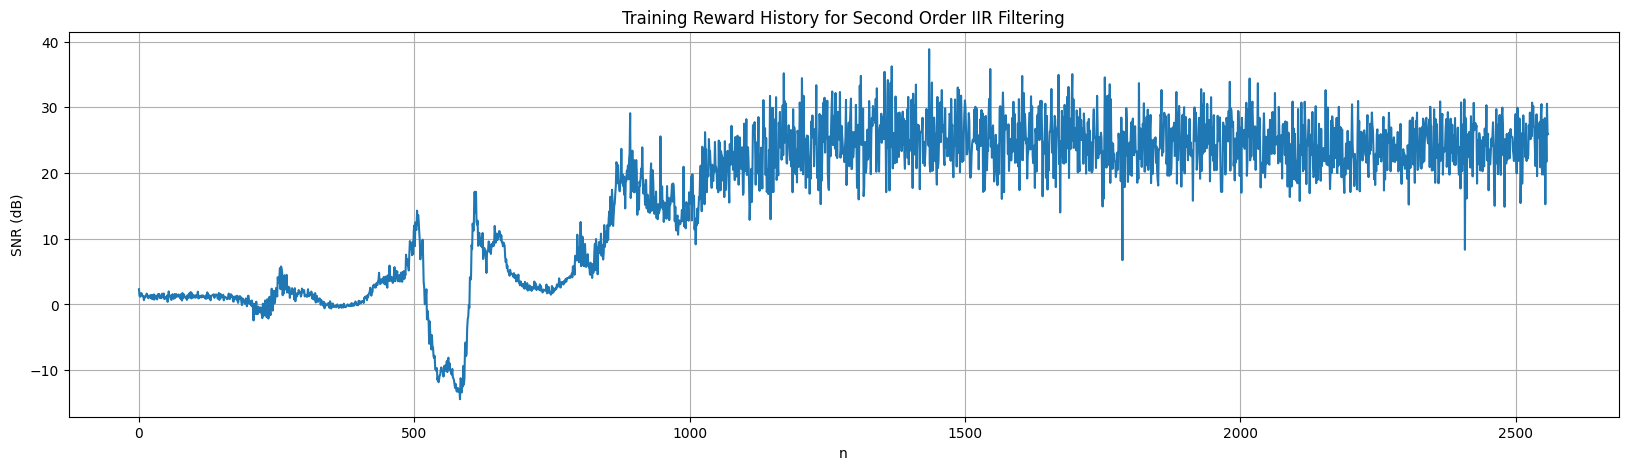

In [32]:
# plotting the results
plt.figure(figsize=(20, 5))
plt.plot(reward_history)
plt.title("Training Reward History for Second Order IIR Filtering")
plt.xlabel("n")
plt.ylabel("SNR (dB)")
plt.grid(True)

### **Launch a DDPG Agent using SB3** 

- Now, we must create a DDPG agent using the `DDPG` class available in SB3 library with the same hyperparameters used in our current custom DDPG model. 
- A copy of the initialization of the custom model with the hyperparameters is given below. 

```
model = DDPGAgent(
    input_dims  = env.observation_space.shape,
    n_actions   = env.action_space.shape[0],
    alpha       = 0.0001, # learning rate of actor
    beta        = 0.001,  # learning rate of critic
    gamma       = 0.1,
    tau         = 0.001,
    critic_fc1  = 512,
    critic_fc2  = 256, #...
    actor_fc1   = 256,
    actor_fc2   = 128,
    batch_size  = 128,
    buffer_size = 2000,
    noise       = 0.01
)
```
- Note: SB3 treat DDPG as a special case of its successor TD3.

> You are correct that the DDPG algorithm requires the critic network to take state-action pairs as the input, as described in the original paper1. However, the stable baselines3 implementation of DDPG uses a different architecture for the critic network, which is based on the TD3 algorithm2. The TD3 algorithm is an extension of DDPG that addresses some of its limitations, such as overestimation bias and function approximation errors2.

> The TD3 critic network consists of two Q-functions, each with its own set of parameters, that take state-action pairs as the input2. However, the action input is only used for the current state, not for the next state. For the next state, the action input is replaced by the output of the actor network, which is a deterministic policy that takes only the state as the input2. This is done to reduce the overestimation bias that arises from using the same action input for both the current and the next state2.

> The stable baselines3 DDPG critic network follows the same architecture as the TD3 critic network, except that it uses only one Q-function instead of two3. This means that the critic network still takes state-action pairs as the input, but only for the current state. For the next state, the action input is replaced by the output of the actor network, which takes only the state as the input3. This is why the stable baselines3 DDPG critic network appears to take only the observations as the input, but in fact it also uses the actions internally3.

### Instantiate a DDPG model

In [65]:
# instantiate the enviroment 
env = ReceiverEnvWithSecondOrderIIR_1(S, CUT_OFF_FREQ, INTERFERENCE_CENTER_FREQ)

# network architecture
net_arch = {
    "qf": [512, 512, 256], # critic (value function) network # ENLARGE THIS LATER
    "pi": [256, 256, 128]  # actor  (policy/pi) network
}

# define the exploration noise as a Gaussian noise
exploration_noise = NormalActionNoise(
    mean = np.zeros(env.action_space.shape),
    sigma = np.ones(env.action_space.shape) * 0.01
)

DDPG_model = DDPG(
    policy = 'MlpPolicy',
    env = env,
    learning_rate = 0.000004, # learning rate for both actor and critic 
    buffer_size = 4_000, 
    learning_starts = 256, # ambiguous
    batch_size = 128,
    tau = 0.001,
    gamma = 0.1,
    train_freq = (1, "step"), # important, the frequency of learning
    gradient_steps = -1, # ambiguous
    action_noise = exploration_noise,
    verbose = 1,
    seed = None, # fix to achieve deterministic behavior
    policy_kwargs = {'net_arch': net_arch}
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### Define a custom evaluate function (from the SB3 Tutorial 1)

In [23]:
from stable_baselines3.common.base_class import BaseAlgorithm

def evaluate(
    model: BaseAlgorithm,
    num_steps: int = 100,
    deterministic: bool = False,
    audio_num: int = 0,
    show_effect: bool = True
) -> float:
    """
    Evaluate an RL agent for `num_episodes`.

    :param model: the RL Agent
    :param env: the gym Environment
    :param num_episodes: number of episodes to evaluate it
    :param deterministic: Whether to use deterministic or stochastic actions
    :return: Mean reward for the last `num_episodes`
    """
    # This function will only work for a single environment
    vec_env = model.get_env()
    # NOTE:- (from documentation) only the initial call to vec_env.reset() is required, environments are reset automatically afterward (and reset_infos is updated automatically).
    obs = vec_env.reset()
    all_rewards = []
    for _ in range(num_steps):
        # _states are only useful when using LSTM policies
        # `deterministic` is to use deterministic actions
        action, _states = model.predict(obs, deterministic=deterministic)
        # here, action, rewards and dones are arrays
        # because we are using vectorized env
        obs, reward, done, _info = vec_env.step(action)
        all_rewards.append(reward)

        if done: break

    return all_rewards

### Train the Model

In [66]:
DDPG_model.learn(total_timesteps = 128*20)


--------------------------------------------------episode no: 1--------------------------------------------------
audio name: 'arms_around_you-MONO'
sampling rate: 44100 Hz
audio shape: (8631296,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -31316.608957868415 (>=-32768) to max: 31370.627685823245 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 47706 and upper -33914 indices
generating the jammed signal...
	creating a non-overlapping interference signal around 15000Hz with a bandwidth of 10000Hz
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -49140.51895186492 (>=-2147483648) to max: 49149.0 (<=2147483647)

step: 1, SNR: -4.412920742985484, filter: [0.6501655  0.32693661 0.04110017], [1.         1.63012405 0.71775739]
step: 2, SNR: -0.07856734185160412, filter: [0.90540588 0.6811438  0.16272091], [1.    

/home/akila/FYP/coding/stage_3/../stage1_helper.py:278: RuntimeWarning: invalid value encountered in log10
  return 10 * np.log10(power(X)/power(Y-X))


step: 224, SNR: -5.297743539105669, filter: [0.86747289 0.18920513 0.01436412], [1.         0.85323082 0.29180464]
step: 225, SNR: 5.521935882378436, filter: [0.54324335 0.34384511 0.06641647], [ 1.         -0.17162679  0.05649247]
step: 226, SNR: -1.0211113547881128, filter: [0.69029874 0.22085172 0.22755213], [1.         0.62381942 0.23403726]
step: 227, SNR: -5.607732716104992, filter: [ 0.19780415 -0.05872402  0.16941171], [ 1.         -1.48711361  0.59185823]
step: 228, SNR: 2.290075944448156, filter: [0.28459826 0.0382528  0.15509189], [1.         0.09545502 0.04928347]
step: 229, SNR: 12.55992029005519, filter: [0.23534533 0.22399806 0.23391221], [ 1.         -0.49153448  0.06633136]
step: 230, SNR: -0.27719910176222917, filter: [ 0.82974291 -0.00221049  0.50298485], [ 1.         -0.24275277  0.22544338]
step: 231, SNR: 1.81719402547616, filter: [0.66254985 0.59587787 0.63214212], [1.         0.05341666 0.00258251]
step: 232, SNR: -5.483304247688975, filter: [ 0.47457811 -0.3583

### Evaluate the Model

In [52]:
rewards = evaluate(
    DDPG_model,
    num_steps = 128 * 20,
    deterministic = True,
    audio_num = 1
)


--------------------------------------------------episode no: 2--------------------------------------------------
audio name: 'arms_around_you-MONO'
sampling rate: 44100 Hz
audio shape: (8631296,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -31316.608957868415 (>=-32768) to max: 31370.627685823245 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 47706 and upper -33914 indices
generating the jammed signal...
	creating a non-overlapping interference signal around 15000Hz with a bandwidth of 10000Hz
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -49140.51895186492 (>=-2147483648) to max: 49149.0 (<=2147483647)

step: 1, SNR: 2.619001078639341, filter: [ 0.06862551 -0.00594548  0.00014924], [ 1.         -1.16055677  0.37893282]
step: 2, SNR: 3.245110915135041, filter: [ 0.08108109 -0.01143353  0.00044286], [ 

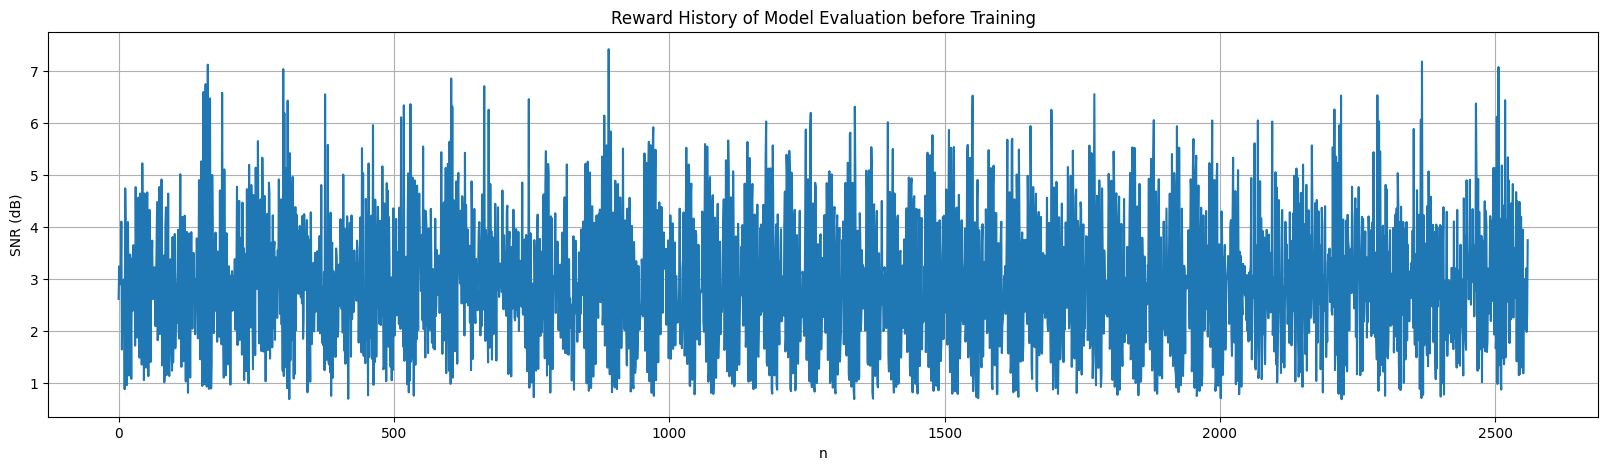

In [53]:
# plotting the results
plt.figure(figsize=(20, 5))
plt.plot(rewards)
plt.title("Reward History of Model Evaluation before Training")
plt.xlabel("n")
plt.ylabel("SNR (dB)")
plt.grid(True)